In [1]:
# --- CELDA 1: INSTALACIÓN ---
# Instalar las librerías necesarias.
# - diffusers y transformers: Para descargar y usar el modelo Stable Diffusion.
# - accelerate: Para optimizar el uso de la GPU.
# - streamlit: Para crear la aplicación web.
# - pyngrok: Para crear un túnel y ver la app desde Colab.

print("Instalando librerías... Esto puede tardar unos minutos.")
!pip install diffusers transformers accelerate scipy safetensors streamlit -q
print("Instalación completada.")

Instalando librerías... Esto puede tardar unos minutos.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.7 MB/s eta 0:00:00
Instalación completada.


Cargando modelo base (runwayml/stable-diffusion-v1-5) en cuda...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


Ejecutando Experimento A: comparación de schedulers...


  0%|          | 0/25 [00:00<?, ?it/s]

PNDM - tiempo de generación: 5.52 segundos


  0%|          | 0/25 [00:00<?, ?it/s]

Euler - tiempo de generación: 5.11 segundos


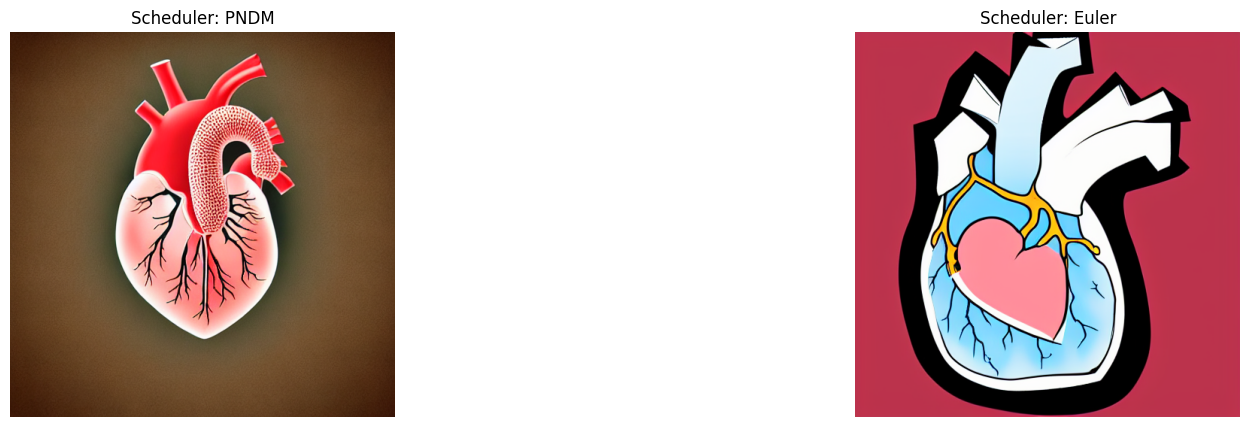


Ejecutando Experimento B: impacto de los 'inference steps'...


  0%|          | 0/15 [00:00<?, ?it/s]

15 pasos - tiempo de generación: 3.19 segundos


  0%|          | 0/50 [00:00<?, ?it/s]

50 pasos - tiempo de generación: 10.08 segundos


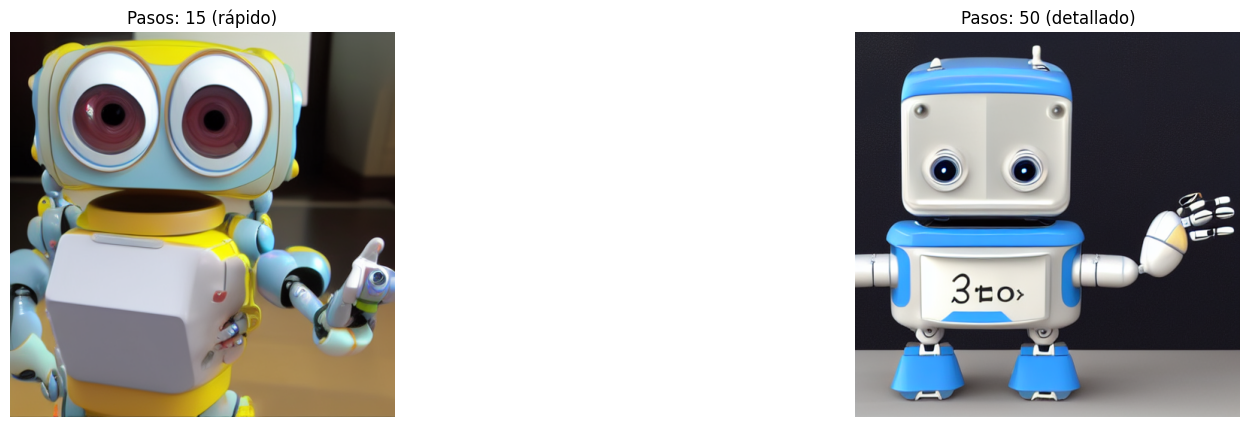

Experimentación finalizada. Estas imágenes y tiempos se pueden usar como evidencia en el informe.

Ejecutando Experimento C: impacto del guidance_scale...
Generando imagen con guidance_scale = 5.0...


  0%|          | 0/30 [00:00<?, ?it/s]

Generando imagen con guidance_scale = 7.5...


  0%|          | 0/30 [00:00<?, ?it/s]

Generando imagen con guidance_scale = 10.0...


  0%|          | 0/30 [00:00<?, ?it/s]

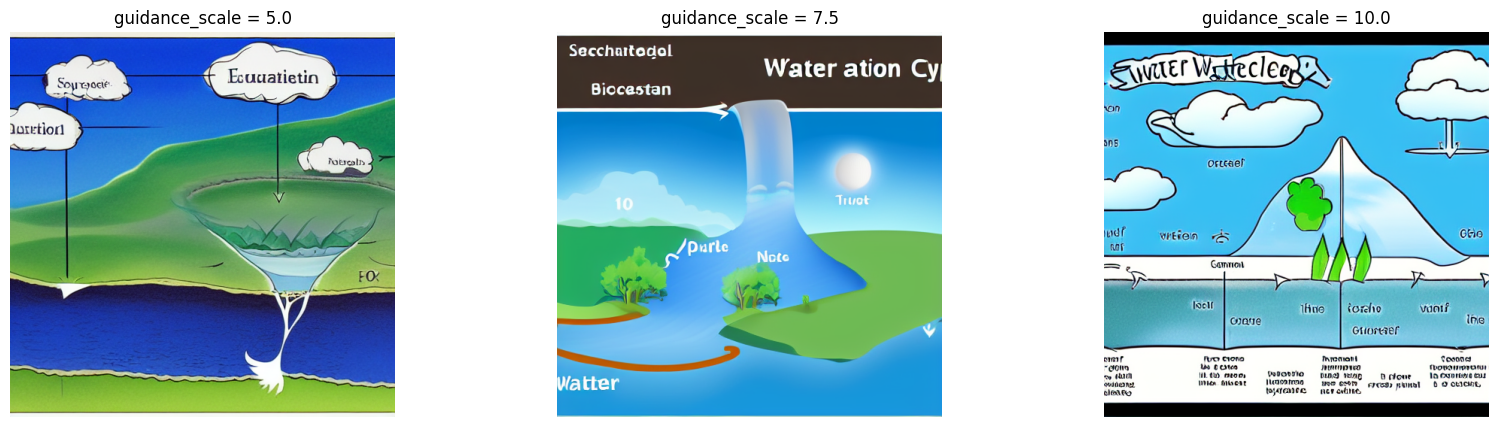

Experimento C finalizado.


In [4]:
# --- CELDA 2: EXPERIMENTACIÓN Y GENERACIÓN DE EVIDENCIA ---

import time
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, PNDMScheduler
import matplotlib.pyplot as plt

# 1. Configuración del dispositivo (uso de GPU si está disponible)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5"

print(f"Cargando modelo base ({model_id}) en {device}...")

# Selección de tipo de dato según el dispositivo
dtype = torch.float16 if device == "cuda" else torch.float32

# Carga del modelo en formato optimizado
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
pipe = pipe.to(device)

# Optimizaciones para reducir uso de memoria y mejorar rendimiento
pipe.enable_attention_slicing()
pipe.enable_vae_tiling()

# Semilla fija para garantizar reproducibilidad en los experimentos
generator = torch.Generator(device=device).manual_seed(42)

# Función auxiliar para mostrar varias imágenes en una misma fila
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].set_title(titles[i])
        axs[i].axis("off")
    plt.show()


# --- EXPERIMENTO A: Comparación de schedulers (algoritmos de muestreo de ruido) ---
print("\nEjecutando Experimento A: comparación de schedulers...")
prompt_exp = "educational illustration of a human heart, anatomical, clear diagram"

# Caso 1: PNDM Scheduler (usado por defecto en muchas configuraciones)
pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)
start = time.time()
img_pndm = pipe(
    prompt_exp,
    num_inference_steps=25,
    height=512,
    width=512,
    generator=generator
).images[0]
end = time.time()
print(f"PNDM - tiempo de generación: {end - start:.2f} segundos")

# Caso 2: Euler Discrete (suele ser más rápido y genera más contraste)
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
start = time.time()
img_euler = pipe(
    prompt_exp,
    num_inference_steps=25,
    height=512,
    width=512,
    generator=generator
).images[0]
end = time.time()
print(f"Euler - tiempo de generación: {end - start:.2f} segundos")

show_images([img_pndm, img_euler], ["Scheduler: PNDM", "Scheduler: Euler"])


# --- EXPERIMENTO B: Pasos de inferencia (relación entre calidad y tiempo de generación) ---
print("\nEjecutando Experimento B: impacto de los 'inference steps'...")
prompt_steps = "3d cute robot teaching mathematics, pixar style"

# Generación con 15 pasos (más rápido, menor nivel de detalle)
start = time.time()
img_15 = pipe(
    prompt_steps,
    num_inference_steps=15,
    height=512,
    width=512,
    generator=generator
).images[0]
end = time.time()
print(f"15 pasos - tiempo de generación: {end - start:.2f} segundos")

# Generación con 50 pasos (más lento, mayor convergencia y detalle)
start = time.time()
img_50 = pipe(
    prompt_steps,
    num_inference_steps=50,
    height=512,
    width=512,
    generator=generator
).images[0]
end = time.time()
print(f"50 pasos - tiempo de generación: {end - start:.2f} segundos")

show_images([img_15, img_50], ["Pasos: 15 (rápido)", "Pasos: 50 (detallado)"])

print("Experimentación finalizada. Estas imágenes y tiempos se pueden usar como evidencia en el informe.")

# --- EXPERIMENTO C: Impacto del guidance_scale (fidelidad al texto vs naturalidad) ---
print("\nEjecutando Experimento C: impacto del guidance_scale...")

prompt_guidance = "educational illustration of the water cycle, simple, clear diagram"

guidance_values = [5.0, 7.5, 10.0]
images_guidance = []
titles_guidance = []

for g in guidance_values:
    print(f"Generando imagen con guidance_scale = {g}...")
    img = pipe(
        prompt_guidance,
        num_inference_steps=30,
        height=512,
        width=512,
        guidance_scale=g,
        generator=generator
    ).images[0]
    images_guidance.append(img)
    titles_guidance.append(f"guidance_scale = {g}")

show_images(images_guidance, titles_guidance)
print("Experimento C finalizado.")


In [6]:
# --- CELDA: GUARDADO DE EVIDENCIA GRÁFICA ---

# Guardado de algunas imágenes representativas de cada experimento.

# Experimento A: comparación de schedulers
img_pndm.save("expA_pndm_heart.png")
img_euler.save("expA_euler_heart.png")

# Experimento B: comparación de pasos de inferencia
img_15.save("expB_robot_15steps.png")
img_50.save("expB_robot_50steps.png")

# Experimento C: variación de guidance_scale
for g, img in zip(guidance_values, images_guidance):
    filename = f"expC_watercycle_guidance_{g}.png"
    img.save(filename)
    print(f"Imagen guardada: {filename}")

print("Guardado de imágenes completado. descargarlas desde el panel de archivos de Colab.")


Imagen guardada: expC_watercycle_guidance_5.0.png
Imagen guardada: expC_watercycle_guidance_7.5.png
Imagen guardada: expC_watercycle_guidance_10.0.png
Guardado de imágenes completado. descargarlas desde el panel de archivos de Colab.


In [7]:
# --- CELDA 3: ESCRIBIR EL CÓDIGO DE LA APP ---
%%writefile app.py

import streamlit as st
import torch
from diffusers import StableDiffusionPipeline

# Configuración general de la página de Streamlit
# Aquí defino el título, el icono y el tipo de layout que tendrá la aplicación web.
st.set_page_config(page_title="EduImagina AI", page_icon=None, layout="wide")

# Bloque de estilos CSS para darle una apariencia más limpia y coherente a la interfaz.
st.markdown("""
<style>
    .main {background-color: #f0f2f6;}
    h1 {color: #2c3e50;}
    .stButton>button {
        background-color: #4CAF50;
        color: white;
        border-radius: 10px;
        padding: 0.4rem 1rem;
        border: none;
    }
</style>
""", unsafe_allow_html=True)


# Carga del modelo con caché para no descargarlo ni inicializarlo en cada recarga de la app.
# Esta función se ejecuta una sola vez y luego reutiliza el mismo pipeline en memoria.
@st.cache_resource
def load_model():
    model_id = "runwayml/stable-diffusion-v1-5"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ajusto el tipo de dato según el dispositivo para evitar problemas en CPU.
    dtype = torch.float16 if device == "cuda" else torch.float32

    # Carga del modelo base de Stable Diffusion.
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
    pipe = pipe.to(device)

    # Optimizaciones para reducir el uso de memoria y hacer la generación más estable.
    pipe.enable_attention_slicing()
    pipe.enable_vae_tiling()

    return pipe, device


# Muestro un indicador de carga mientras el modelo se inicializa.
with st.spinner("Cargando el modelo generativo. Esta operación se realiza una sola vez."):
    pipe, device = load_model()


# Encabezado principal de la aplicación.
st.title("EduImagina: Ilustrador de Conceptos Educativos")
st.markdown(
    "Esta herramienta genera material visual didáctico, pensado para apoyar la explicación de conceptos en el aula."
)

# Defino un layout con dos columnas: la primera para la configuración y la segunda para los resultados.
col1, col2 = st.columns([1, 2])

with col1:
    st.subheader("Configuración")

    # Entrada principal: concepto o tema que el docente quiere ilustrar.
    topic = st.text_input("¿Qué concepto quieres enseñar?", "El sistema solar")

    # Selector de estilo visual. Cada opción se traduce internamente en un tipo de prompt distinto.
    style_option = st.selectbox(
        "Estilo visual",
        (
            "Libro de texto (diagrama)",
            "Cartoon 3D (infantil)",
            "Realista (secundaria)",
            "Arte pixel (gamificación)",
        ),
    )

    # Diccionario que mapea cada estilo a un fragmento de prompt más detallado.
    style_prompts = {
        "Libro de texto (diagrama)": "educational diagram, clean white background, textbook style, high detail, schematic",
        "Cartoon 3D (infantil)": "pixar style, 3d render, cute, vibrant colors, soft lighting, 4k",
        "Realista (secundaria)": "national geographic photo, highly detailed, cinematic lighting, 8k",
        "Arte pixel (gamificación)": "pixel art, 16-bit, retro game style",
    }

    # Controles de hiperparámetros expuestos al usuario.
    # Estos parámetros permiten ajustar el balance entre calidad visual, tiempo de inferencia y fidelidad al texto.
    num_inference_steps = st.slider(
        "Pasos de inferencia",
        min_value=15,
        max_value=50,
        value=30,
        step=5,
        help="A mayor número de pasos, mejor detalle pero mayor tiempo de generación.",
    )

    guidance_scale = st.slider(
        "Guidance scale",
        min_value=5.0,
        max_value=12.0,
        value=7.5,
        step=0.5,
        help="Controla qué tanto el modelo sigue el texto. Valores muy altos pueden producir imágenes forzadas o menos naturales.",
    )

    # Nota ética visible directamente en la interfaz.
    st.info(
        "Nota ética: Las imágenes son generadas por inteligencia artificial. "
        "Es importante que el docente verifique la precisión científica y el contexto antes de usar el material en clase."
    )

    generate_btn = st.button("Generar material")

with col2:
    st.subheader("Resultado")

    if generate_btn:
        if not topic.strip():
            # Mensaje de validación simple para evitar solicitudes vacías.
            st.warning("Por favor ingresa un concepto o tema antes de generar la ilustración.")
        else:
            # Construcción del prompt final a partir del tema y del estilo seleccionado.
            base_prompt = f"{topic}, {style_prompts[style_option]}"

            # Prompt negativo para intentar filtrar artefactos comunes y contenido no deseado.
            negative_prompt = (
                "distorted, blurry, text, watermark, violent, nudity, deformed hands, bad anatomy"
            )

            with st.spinner(f"Generando ilustración para el concepto: '{topic}'..."):
                # Llamada al pipeline de Stable Diffusion con los parámetros configurables.
                image = pipe(
                    prompt=base_prompt,
                    negative_prompt=negative_prompt,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    height=512,
                    width=512,
                ).images[0]

                # Muestra de la imagen generada junto con una breve descripción.
                st.image(image, caption=f"Concepto ilustrado: {topic}", use_column_width=True)

                # Mensaje de confirmación para indicar que la generación ha finalizado.
                st.success(
                    "La ilustración se ha generado correctamente. Puedes descargarla o incorporarla en tu material de clase."
                )


Overwriting app.py
